In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
from scipy import stats,special
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm
import matplotlib.markers as mmarkers
from matplotlib.colors import SymLogNorm
import math
import time
import h5py

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

import innvestigate
import innvestigate.utils as iutils


import os
import pickle

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


In [2]:
import sys
sys.path.append('../python/')
from analysisHelper import *
from networkBuilder import *

In [3]:
# Show all numbers as float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

## Global parameters

In [4]:
# Transparency of Histograms
transp=0.6

In [5]:
# Set default options for paper
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white',
         'hatch.linewidth': 2.0}
plt.rcParams.update(params)
plt.style.context('default')

In [6]:
feature_names={'jetPt':r'$p_{T,jet}$',
               'jetEta':r'$\eta(jet)$',
               'jetPhi':r'$\phi(jet)$',
               'jetMass':r'$m_{jet}$',
               'jetMassSD':r'$m_{jet,sd}$',
               'tau1_b05':r'$\tau_{1}^{(0.5)}$',
               'tau2_b05':r'$\tau_{2}^{(0.5)}$',
               'tau3_b05':r'$\tau_{3}^{(0.5)}$',
               'tau1_sd_b05':r'$\tau_{1,sd}^{(0.5)}$',
               'tau2_sd_b05':r'$\tau_{2,sd}^{(0.5)}$',
               'tau3_sd_b05':r'$\tau_{3,sd}^{(0.5)}$',
               'tau1_b10':r'$\tau_{1}^{(1)}$',
               'tau2_b10':r'$\tau_{2}^{(1)}$',
               'tau3_b10':r'$\tau_{3}^{(1)}$',
               'tau1_sd_b10':r'$\tau_{1,sd}^{(1)}$',
               'tau2_sd_b10':r'$\tau_{2,sd}^{(1)}$',
               'tau3_sd_b10':r'$\tau_{3,sd}^{(1)}$',
               'tau1_b20':r'$\tau_{1}^{(2)}$',
               'tau2_b20':r'$\tau_{2}^{(2)}$',
               'tau3_b20':r'$\tau_{3}^{(2)}$',
               'tau1_sd_b20':r'$\tau_{1,sd}^{(2)}$',
               'tau2_sd_b20':r'$\tau_{2,sd}^{(2)}$',
               'tau3_sd_b20':r'$\tau_{3,sd}^{(2)}$',
               'chMult':r'$N_{ch}$',
               'neutMult':r'$N_{neut}$',
               'phoMult':r'$N_{\gamma}$',
               'eleMult':r'$N_{e}$',
               'muMult':r'$N_{\mu}$',
               'jetpull_abs':r'$|\phi_{pull}$|',
               'beta3':r'$\beta_{3}$',
               'beta3_sd':r'$\beta_{3}^{g}$',
               'tau21':r'$\tau_{2}^{(1)} / \tau_{1}^{(1)}$',
               'deltaR_subjets':r'$\Delta R_{subjets}$',
               'z':r'$z$',
               'dxy_max':r'$d_{xy,max}$',
               'dz_max':r'$d_{z,max}$',
               'jetImages':r'Image'
              }

## Useful Functions

In [7]:
def Get_LRP_Score(data,model,LRP_fct):
    
    # Strip model of softmax function for LRP
    model_ws = iutils.keras.graph.model_wo_softmax(model)
    
    # Build LRP analyzer
    lrp_analyzer = innvestigate.create_analyzer(LRP_fct, model_ws)
    lrp_score = [lrp_analyzer.analyze(ele) for ele in data]
    return lrp_score

In [8]:
def get_mean_relevance_test(lrp_models=[], lrp_xaugs_models=[], model_pred=[], batchShape=[20], usePred=True, isSum=False, abs=True):

    # lrp_models = list of lrp (images or particle list) score arrays to average over                                                                        
    # lrp_xaugs_models = list of xaug lrp scores                               
    # batchShape =  [20] for particle list: number of constituent particles per event                                                                        
    #               [16, 16] for jet images: grid shape                        
    # isSum = True or False : take sum of relevance of image grid pixels (True) or take maximum relevance (False)                                            



    lrp_mean = []
    lrp_xaugs_mean = []
    lrp_std = []
    lrp_xaugs_std = []

    lrp_axis = (0,2,3)
    if(len(batchShape)==2):
        lrp_axis = (0,2,3)

    if((len(lrp_models) > 0)):
        
        if ((len(batchShape)==2) and (isSum)):
            if abs: lrp_models = np.sum(np.abs(lrp_models),axis = (3,4)) # sum only along image grid  
            else:   lrp_models = np.sum(lrp_models,axis = (3,4)) # sum only along image grid
        elif ((len(batchShape)==2) and not(isSum)):
            lrp_models = np.max(lrp_models,axis = (3,4)) # max only along image grid                                                                         

        print(lrp_models)
        print(np.mean(lrp_models[0]))
        if usePred: lrp_models = [lrp_models[0]*model_pred[0]]
        print(lrp_models)
        print(np.mean(lrp_models[0]))
        nEvents = lrp_models[0].shape[1]
        print (nEvents)

        if(len(batchShape)==2):
            if abs: lrp_means = np.sum(np.abs(lrp_models), axis=lrp_axis[1:]) / (nEvents)
            else:   lrp_means = np.sum(lrp_models, axis=lrp_axis[1:]) / (nEvents)
            print (np.max(np.abs(lrp_models), axis=lrp_axis[1:]))
            print (lrp_means)
        else:
            if abs: lrp_means = np.sum(np.abs(lrp_models), axis=lrp_axis[1:]) / (np.prod(batchShape)*nEvents)
            else:   lrp_means = np.sum(lrp_models, axis=lrp_axis[1:]) / (np.prod(batchShape)*nEvents)
        lrp_mean = np.sum(lrp_means, axis=0) / (len(lrp_models))
        lrp_std = np.std(lrp_means, axis=0)



    if(len(lrp_xaugs_models) > 0):
        if usePred: lrp_xaugs_models = [lrp_xaugs_models[0]*model_pred[0]]
        nEvents = lrp_xaugs_models[0].shape[1]
        if abs: lrp_xaugs_means = np.sum(np.abs(lrp_xaugs_models), axis=(2,3)) / nEvents
        else:   lrp_xaugs_means = np.sum(lrp_xaugs_models, axis=(2,3)) / nEvents
        print (lrp_xaugs_means)
        lrp_xaugs_mean = np.sum(lrp_xaugs_means, axis=0) / len(lrp_xaugs_models)
        lrp_xaugs_std = np.std(lrp_xaugs_means, axis=0)


    lrp_mean_list = [lrp for lrp in lrp_mean] + [lrp for lrp in lrp_xaugs_mean]
    lrp_std_list = [std for std in lrp_std] + [lrp for lrp in lrp_xaugs_std]

    return lrp_mean_list, lrp_std_list

In [9]:
def Confusion_Split(X,Y,pred,confidence_cut):
    ind_true_positive = np.argwhere((pred[:,0,1] > confidence_cut) & (Y[0][:,1] == 1))
    ind_true_negative = np.argwhere((pred[:,0,0] > confidence_cut) & (Y[0][:,0] == 1))
    ind_false_positive = np.argwhere((pred[:,0,1] > confidence_cut) & (Y[0][:,0] == 1))
    ind_false_negative = np.argwhere((pred[:,0,0] > confidence_cut) & (Y[0][:,1] == 1))
    
    LRP_tp = X[ind_true_positive]
    LRP_tn = X[ind_true_negative]
    LRP_fp = X[ind_false_positive]
    LRP_fn = X[ind_false_negative]
    return LRP_tp, LRP_tn, LRP_fp, LRP_fn

In [10]:
def SigBkg_Split(LRP,X,Y):
    ind_sig = np.argwhere((Y[0][:,1] == 1))
    ind_bkg = np.argwhere((Y[0][:,0] == 1))

    LRP_sig = LRP[ind_sig]
    LRP_bkg = LRP[ind_bkg]
    X_sig = X[ind_sig]
    X_bkg = X[ind_bkg]
    return LRP_sig, LRP_bkg, X_sig, X_bkg

In [11]:
def getLabeledPrediction(pred, Y):
    return (pred.squeeze()*Y[0])[:,:1] + (pred.squeeze()*Y[0])[:,1:]

In [12]:
def Draw_LRP_Image(LRP_tp, LRP_tn, LRP_fp, LRP_fn, LRP_fct):
    LRP_tp_mean = np.mean(LRP_tp, axis = 0).reshape(16,16)
    LRP_tn_mean = np.mean(LRP_tn, axis = 0).reshape(16,16)
    LRP_fp_mean = np.mean(LRP_fp, axis = 0).reshape(16,16)
    LRP_fn_mean = np.mean(LRP_fn, axis = 0).reshape(16,16)
    fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize = (10,10))
#    fig.suptitle('Images from ' + LRP_fct + ' algorithm')
    fig.tight_layout()
    im0 = ax[0][0].imshow(LRP_tp_mean,
                        interpolation = 'nearest',
                        origin = 'low',
                        #norm = SymLogNorm(linthresh = 0.001, base = 10),
                        norm = SymLogNorm(linthresh=0.001),
                        cmap = 'RdBu',
                        vmin = -10,
                        vmax = 10)
    ax[0][0].set_title('True Signal Images')
    cb0 = fig.colorbar(im0, shrink = 0.8, ax = ax[0][0])
    

    
    im1 = ax[1][1].imshow(LRP_tn_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          #norm = SymLogNorm(linthresh = 0.001, base = 10),
                          norm = SymLogNorm(linthresh=0.001),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10,
                          extent = [-8.0, 8.0, -8.0, 8.0])
    ax[1][1].set_title('True Background Images')
    cb1 = fig.colorbar(im1,shrink=0.8, ax=ax[1][1])
    
    im2 = ax[0][1].imshow(LRP_fp_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          #norm = SymLogNorm(linthresh = 0.001,base = 10),
                          norm = SymLogNorm(linthresh=0.001),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10)
    ax[0][1].set_title('False Signal Images')
    fig.colorbar(im2, shrink = 0.8, ax = ax[0][1])
    
    im3 = ax[1][0].imshow(LRP_fn_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          #norm = SymLogNorm(linthresh = 0.001,base = 10),
                          norm = SymLogNorm(linthresh=0.001),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10)
    ax[1][0].set_title('False Background Images')
    fig.colorbar(im3,shrink = 0.8, ax = ax[1][0])
    plt.savefig('plots/LRP/LRP_jetImages_imonly_' + LRP_fct + '.png')

In [13]:
def Make_LRP_Images(model,X,Y,LRP_fct,confidence_cut,standardize=True):
    pred = np.array([model.predict(ele) for ele in X])
    LRP_diff = Get_LRP_Score(X,
                             model,
                             LRP_fct)
    
    LRP_diff = np.array(LRP_diff).reshape(len(LRP_diff),grid,grid)
    
    LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_diff,
                                                     Y,
                                                     pred,
                                                     confidence_cut)
    if standardize:
        LRP_tp_std = np.array([stand(ele) for ele in LRP_tp])
        LRP_tn_std = np.array([stand(ele) for ele in LRP_tn])
        LRP_fp_std = np.array([stand(ele) for ele in LRP_fp])
        LRP_fn_std = np.array([stand(ele) for ele in LRP_fn])
    else:
        LRP_tp_std = LRP_tp
        LRP_tn_std = LRP_tn
        LRP_fp_std = LRP_fp
        LRP_fn_std = LRP_fn
    
    Draw_LRP_Image(LRP_tp_std,
                   LRP_tn_std,
                   LRP_fp_std,
                   LRP_fn_std,
                   LRP_fct)

In [84]:
def plot_heatmaps_eventwise(X_test,Y_test,norm_relevance1):
    plt.rc('font', family='serif')
    fig, axs = plt.subplots(2,4, figsize=(14, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=.2)
    fig.subplots_adjust(top=0.83)   
    axs = axs.ravel()
    
    X_test = X_test[0].squeeze()
    
    LRP_sig, LRP_bkg, X_sig, X_bkg = SigBkg_Split(norm_relevance1,X_test,Y_test)
    
    for i in range(4):
        if (i==0 or i==1):
            im1 = axs[i].imshow(X_sig[i].squeeze(),
                      interpolation = 'nearest',
                      norm = SymLogNorm(linthresh=0.001),
                      cmap = 'Greens',
                      vmin = 0,
                      vmax = 1.0,
                      extent = [-2, 2, -2, 2])
            im2 = axs[i+4].imshow(LRP_sig[i].squeeze(),
                      interpolation = 'nearest',
                      norm = SymLogNorm(linthresh=0.001),
                      cmap = 'RdBu',
                      vmin = -1,
                      vmax = 1,
                      extent = [-2, 2, -2, 2])
            if i==0:
                axs[i].set_ylabel(r'Transformed $\phi$')
                axs[i+4].set_ylabel(r'Transformed $\phi$')
        else:
            im1 = axs[i].imshow(X_bkg[i].squeeze(),
                      interpolation = 'nearest',
                      norm = SymLogNorm(linthresh=0.001),
                      cmap = 'Greens',
                      vmin = 0,
                      vmax = 1.0,
                      extent = [-2, 2, -2, 2])
            im2 = axs[i+4].imshow(LRP_bkg[i].squeeze(),
                                  interpolation='nearest',
                                  #origin='low',
                                  cmap='RdBu',
                                  norm=SymLogNorm(linthresh=0.0001), 
                                  vmin = -1, 
                                  vmax= 1, 
                                  extent = [-2, 2, -2, 2]
                                 )
        axs[i+4].set_xlabel(r'Transformed $\eta$')
        cbar1 = fig.colorbar(im1, ax=axs[i], fraction=0.0467, pad=0.02)
        cbar2 = fig.colorbar(im2, ax=axs[i+4], fraction=0.0467, pad=0.02)
        if (i==3):
            cbar1.set_label(r'Pixel $p_T$ (GeV)')
            cbar2.set_label(r'Normalized Relevance')
            
            cbar_ticks = np.array([-1,-0.01,0,0.01,1])
            cbar_tick_labels = np.array(['-1','-0.01','0','0.01','1'])
            cbar_mask = np.where((cbar_ticks >= 0.) & (cbar_ticks <= 1.))

            cbar1.set_ticks(cbar_ticks[cbar_mask])
            cbar1.ax.set_yticklabels(cbar_tick_labels[cbar_mask])

            cbar_mask2 = np.where((cbar_ticks >= -1.) & (cbar_ticks <= 1.))
            cbar2.set_ticks(cbar_ticks[cbar_mask2])
            cbar2.ax.set_yticklabels(cbar_tick_labels[cbar_mask2])
        else:
            cbar1.set_ticks([])
            cbar2.set_ticks([])
    plt.figtext(0.318,0.88,"Signal Images and their relevance heatmaps", va="center", ha="center", size=15)
    plt.figtext(0.72,0.88,"Background Images and their relevance heatmaps", va="center", ha="center", size=15)
    plt.savefig('plots/LRP/Pythia_sig-bkg_image_and_heatmap.png', bbox_inches='tight')

In [15]:
def make_profile_data(x,values,bins):
    bin_mean, bin_edges, _ = stats.binned_statistic(x,
                                                    values,
                                                    statistic = 'mean',
                                                    bins = bins,
                                                    range = (0,1))
    bin_std, _, _ = stats.binned_statistic(x,
                                           values,
                                           statistic = 'std',
                                           bins = bins,
                                           range = (0,1))
    bin_count, _, _ = stats.binned_statistic(x,
                                             x,
                                             statistic = 'count',
                                             bins = bins,
                                             range = (0,1))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_mean, bin_std, bin_count, bin_edges, bin_centers, bin_width 

In [16]:
def stand(array):
    if np.std(array) == 0:
        return array - np.mean(array)
    else:
        return (array - np.mean(array))/np.std(array)

In [17]:
def Draw_Profile_small(X_test, Y_test, pred, LRP_norm, confidence_cut, feat, bins, histomax, relmin, relmax):
    ii = features.index(feat)
    ind_positive = np.argwhere((pred[:,0,1]>confidence_cut)).flatten()
    ind_negative = np.argwhere((pred[:,0,0]>confidence_cut)).flatten()
    LRP_p = np.array(LRP_norm)[ind_positive]
    LRP_n = np.array(LRP_norm)[ind_negative]
    X_p = [feat[ind_positive] for feat in X_test]
    X_n = [feat[ind_negative] for feat in X_test]
    bin_mean_p, bin_std_p, bin_count_p, bin_edges, bin_centers, bin_width = make_profile_data(X_p[ii].flatten(), LRP_p[:,ii], bins)
    bin_mean_n, bin_std_n, bin_count_n, _, _, _  = make_profile_data(X_n[ii].flatten(), LRP_n[:,ii], bins)
    
    bin_mean_p[bin_count_p < 50] = np.nan
    bin_std_p[bin_count_p < 50] = 0
    
    bin_mean_n[bin_count_n < 50] = np.nan
    bin_std_n[bin_count_n < 50] = 0

    fig = plt.figure(figsize=(6,7))
#    fig.suptitle('Histogram and relevance profile for ' + feature_names[ii])
    gs = gridspec.GridSpec(3, 1) 
    gs.update(wspace=0.025, hspace=0.1)
    
    
    
    ax0 = plt.subplot(gs[:2,:])
    ax0.hist(X_p[ii].flatten(),
                bins = bins,
                histtype = 'step',
#                normed=False,
                weights = np.ones(len(X_p[ii].flatten()))/len(X_p[ii].flatten()),
                fill = True,
                alpha = 0.55,
                label = "Signal",
                log = False,
#                density = True,
                range = [0,1],
                hatch='/',
                edgecolor='k'
                );
    ax0.hist(X_n[ii].flatten(),
                bins = bins,
                histtype = 'step',
#                normed=False,
                weights = np.ones(len(X_n[ii].flatten()))/len(X_n[ii].flatten()),
                fill = True,
                alpha = 0.55,
                label = 'Background',
                log = False,
#                density = True,
                range = [0,1],
                hatch = '\\',
                edgecolor='k'
                );
    l = ax0.legend();
#    ax0.grid()
    ax0.set_xlim(0,1)
    ax0.set_ylim(0,histomax)

    ax0.set_ylabel('Fraction')

    ax1 = plt.subplot(gs[2:,:])
    ax1.xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(bin_centers,
             bin_mean_p,
             color = 'C0',
             label = "Signal")
    ax1.plot(bin_centers,
             bin_mean_n,
             color = 'C1',
             label = "Background")
    ax1.fill_between(bin_centers,
                     bin_mean_p - bin_std_p,
                     bin_mean_p + bin_std_p,
                     color = 'C0',
                     alpha = 0.2)
    ax1.fill_between(bin_centers,
                     bin_mean_n - bin_std_n,
                     bin_mean_n + bin_std_n,
                     color = 'C1',
                     alpha = 0.2)
    ax1.grid()
    ax1.set_ylim(relmin,relmax)
    ax1.set_xlim(0, 1)
    ax1.set_ylabel('Relevance')
    ax1.set_xlabel('Normalized ' + feature_names[feat])
    
    plt.savefig('plots/LRP/LRP_' + feat + '.png')

In [ ]:
def make_relevance_bar_plot_test(features, LRP_mean, LRP_std, topN=None, ymax_set=None):

    # features = list of features in same order as LRP_mean                    
    # LRP_mean = array of averaged relevance scores                            
    # LRP_std = standard deviation of averaged relevance scores                
    # topN = number of highest relevance scores to plot (for all features, topN=None)                                                                        


    params = {'legend.fontsize': 'x-large',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'x-large',
     'font.family':'serif',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large',
     'figure.facecolor':'white',
     'axes.grid':True,
     'grid.alpha':1.0
         }

    plt.rcParams.update(params)
    plt.style.context('default')
    mpl.rcParams.update({'hatch.linewidth':2.0})

    size_for_all_features = [15,10]
    size_for_5_features = [7.5,5]
    size = size_for_all_features
    fs = 20 # fontsize of y-label and y-ticks                                  

    if(topN != None):
        if(topN < 20):
            size = size_for_5_features
            fs = 15 # fontsize of y-label and y-ticks                          


    fig = plt.figure(figsize=size )

    LRP_order = [features[i] for i in np.argsort(LRP_mean)]
    LRP_std_sorted = [LRP_std[i] for i in np.argsort(LRP_mean)]
    LRP_order2 = [feature_names[feat] for feat in LRP_order]
    relevances = np.sort(LRP_mean)

    barplot = plt.bar(LRP_order2, relevances)

    xmax = len(LRP_order2)-0.5
    xmin=-0.5
    if(topN==None):
        xmin=-0.5
    else:
        xmin = xmax-topN

    ymin = 0
    ymax = (relevances[-1] + LRP_std_sorted[-1])*1.10
    if ymax_set: ymax = ymax_set

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(fontsize=fs)

    plt.ylabel('Mean Normalized Relevance', fontsize=fs)


    count = 0
    for b in barplot:
        plt.fill_between([b.get_x(), b.get_x() + b.get_width()],
                             b.get_height() - LRP_std_sorted[count],
                             b.get_height() + LRP_std_sorted[count],
                             lw=0,
                             fc='none',
                             ec='k',
                             hatch='//',
                             zorder=2)
        count += 1
        
    fig.tight_layout()
    fig.savefig('LRP_barplot.png')

In [18]:
lrp_algorithms=['lrp', 'lrp.z', 'lrp.z_IB', 'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat']

## Import data:
Using ShowJetsData_full.npz to build the CNN.

In [19]:
grid = 16

In [20]:
test_sig_features = np.load('/mnt/data/ml/PreProcessing/ShowJets_test_Zbb_exts_msd50to150_v2.npz')
test_bkg_features = np.load('/mnt/data/ml/PreProcessing/ShowJets_test_QCD_exts_msd50to150_v2.npz')

In [21]:
test_sig_images = np.load('/mnt/data/ml/PreProcessing/ShowJets_test_Zbb_exts_msd50to150_images_v2.npz')
test_bkg_images = np.load('/mnt/data/ml/PreProcessing/ShowJets_test_QCD_exts_msd50to150_images_v2.npz')

In [ ]:
test_sig = {**test_sig_images, **test_sig_features}
test_bkg = {**test_bkg_images, **test_bkg_features}

In [22]:
#n_test should be the length of the signal plus the background
n_test = 2*len(test_sig_images['labels'])
print(n_test)

276290


# Model with just Images

## LRP

In [23]:
# Drop all events where the model predicted its result with less confidence then this
confidence_cut = 0.0

In [24]:
# Select features and build X_test and Y_test
features = ['jetImages']
label = ['labels']
X_test, Y_test = build_XY(features,label,test_sig_images, test_bkg_images, signal="Zbb")

# Reshape X_test for LRP
X_lrp = [[X_test[i][j] for i in range(len(features))] for j in range(n_test)]
for i in range(n_test):
    X_lrp[i][0] = X_lrp[i][0].reshape(1,grid,grid,1)
Y_lrp = Y_test

In [25]:
# Load Model
model = keras.models.load_model('model/CNN_Images.h1')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [26]:
pred = np.array([model.predict(ele) for ele in X_lrp])

In [ ]:
# Select features and build X_test and Y_test
#features = ['jetImages']
#label = ['labels']
#X_test, Y_test = build_XY(features,label,test_sig, test_bkg, signal="Zbb")

In [ ]:
#predict = model.predict(X_test)
#print(predict)

In [ ]:
#print(Y_test[0])

In [ ]:
#sig_pred = Y_test[(Y_test[0][:,1]==1.)].squeeze()
#bkg_pred = Y_test[(Y_test[0][:,1]==0.)].squeeze()
#plt.hist([sig_pred[:,0], bkg_pred[:,1]], 
         #color = ['blue', 'red'], histtype = 'step', label = ['signal predictions', 'background predictions'])
#plt.xlim(0,1)
#plt.legend()
#plt.show()

### LRP.epsilon

In [ ]:
LRP_fct = 'lrp.epsilon'
LRP_diff = Get_LRP_Score(X_lrp,
                         model,
                         LRP_fct)

In [ ]:
LRP_rediff = np.array([ele[0].reshape(grid,grid)/(np.max(np.abs(ele[0]))+0.000001) for ele in LRP_diff])

In [ ]:
LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_rediff,
                                                 Y_lrp,
                                                 pred,
                                                 confidence_cut)

In [ ]:
#LRP_tn = LRP_tp.reshape(1,16,16)
#LRP_tp_mean = np.mean(LRP_tp, axis = 1).reshape(16,16)
print(LRP_tp)
print(LRP_tp.shape)

In [ ]:
LRP_fct = 'lrp.epsilon'
Draw_LRP_Image(LRP_tp,
                   LRP_tn,
                   LRP_fp,
                   LRP_fn,
                   LRP_fct)

### LRP.epsilon - ignore bias
This should perform worse

In [ ]:
LRP_fct = 'lrp.epsilon_IB'
LRP_diff = Get_LRP_Score(X_lrp,
                         model,
                         LRP_fct)

In [ ]:
LRP_fct = 'lrp.epsilon_IB'
LRP_diff = Get_LRP_Score(X_lrp,
                         model,
                         LRP_fct)

In [ ]:
LRP_rediff = np.array([ele[0].reshape(grid,grid)/(np.max(np.abs(ele[0]))+0.000001) for ele in LRP_diff])

In [ ]:
LRP_fct = 'lrp.epsilon_IB'
Draw_LRP_Image(LRP_tp,
                   LRP_tn,
                   LRP_fp,
                   LRP_fn,
                   LRP_fct)

LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_rediff,
                                                 Y_lrp,
                                                 pred,
                                                 confidence_cut)

### LRP.preset_a

In [27]:
LRP_fct = 'lrp.sequential_preset_a'
LRP_diff = Get_LRP_Score(X_lrp,
                         model,
                         LRP_fct)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
print(LRP_diff)

In [ ]:
extent_sig = [-sig_train_images.shape[1]/2., sig_train_images.shape[1]/2., -sig_train_images.shape[0]/2., sig_train_images.shape[0]/2. ]


In [28]:
LRP_rediff = np.array([ele[0].reshape(grid,grid)/(np.max(np.abs(ele[0]))+0.000001) for ele in LRP_diff])

In [30]:
np.savez('model/LRP_Image', 
         LRP_diff=LRP_diff, LRP_rediff=LRP_rediff
        )

In [ ]:
sig_train_images = np.sum(data_sig_images['jetImages'],axis=0).reshape(grid,grid)

In [ ]:
LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_rediff,
                                                 Y_lrp,
                                                 pred,
                                                 confidence_cut)

In [ ]:
LRP_fct = 'lrp.sequential_preset_a'
Draw_LRP_Image(LRP_tp,
                   LRP_tn,
                   LRP_fp,
                   LRP_fn,
                   LRP_fct)

In [ ]:
print(LRP_tp.shape)
LRP_tp_cp = LRP_tp
LRP_tp_cp[0].reshape(16,16)

In [ ]:
print(test_sig_images['jetImages'].shape)
print(X_test[0].shape)
print(X_test[0][0][:][:][0])
X_test_trial = X_test[0][0].reshape(grid,grid)
print(X_test_trial)
print(n_test)

In [ ]:
X_test_trial = X_test
X_test_trial = X_test_trial[0].reshape(n_test,grid,grid)
#for i in range(2): print(X_test_trial[0][i].reshape(grid,grid))
    #X_test_trial.append(X_test[0][i].reshape(grid, grid))

In [ ]:
print(len(X_test_trial))
print(X_test_trial[0])

In [ ]:
LRP

In [ ]:
print(X_test_trial[0][0])

In [ ]:
print(LRP_rediff[1])

In [ ]:
print(X_lrp[0][0].shape)
print(Y_test[0])

In [ ]:
X_lrp[:,1][Y_test[0][:,1]==1][4].shape

In [ ]:
print((LRP_rediff[2]).shape)

In [ ]:
print(X_test[0].shape)
print(Y_test[0].shape)
print(LRP_rediff.shape)
X_reshaped = X_test[0].squeeze()
print(X_reshaped.shape)

In [ ]:
LRP_sig, LRP_bkg, X_sig, X_bkg = SigBkg_Split(LRP_rediff,X_reshaped,Y_test)

In [ ]:
X_sig[1].squeeze().shape

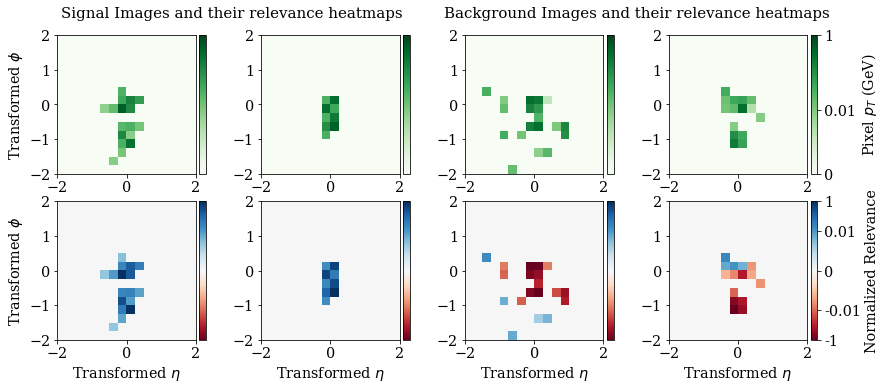

In [85]:
plot_heatmaps_eventwise(X_test,Y_test,LRP_rediff)

# Model with Image + All Expert Variables

## Compare different feature subsets

In [ ]:
loc_ROCs = '/mnt/data/ml/ROCs/'

In [ ]:
fpr=[]
tpr=[]
roc_auc=[]
acc = []
model_names = []
label = ['labels']
for i in range(2):
    if i == 0:
        # features will be loaded into X
        features = ['jetImages']
        name = 'CNN_Images'
        best_model = keras.models.load_model('model/'+name+'.h1')
#     elif i == 1:
#         drop_those = ['jetImages', 'chMult', 'neutMult', 'phoMult', 'eleMult', 'muMult', 'dxy_max', 'dz_max']
#         # features will be loaded into X
#         features = feat_all[:]
#         for feat in drop_those:
#             features.remove(feat)
#         name = 'DNN_noflavour'
#         best_model = keras.models.load_model('model/'+name+'.h1')
    elif i == 1:
#         # features will be loaded into X
#         features = get_feat(True, True, False, False) #xaugs, flavor, images, particleInfo
#         name = 'DNN_all'
#         best_model = keras.models.load_model('model/'+name+'.h1')
#     elif i == 2:
#         #features will be loaded into X
#         features = ['jetImages', 'dz_max', 'dxy_max','jetMassSD', 'tau2_sd_b05', 'tau3_b10']
#         name = 'CNN_5XAUG'
#         best_model = keras.models.load_model('model/'+name+'.h1')
#     elif i == 3:
#         # features will be loaded into X
#         features = get_feat(True,True,True,False)
#         name = 'CNN_all'
#         best_model = keras.models.load_model('model/'+name+'.h1')
#     elif i == 4:
#         # features will be loaded into X
#         features = get_feat(True, True, False, False) #xaugs, flavor, images, particleInfo
#         name = 'DNN_all_defaultopt'
#         best_model = keras.models.load_model('model/'+name+'.h1')
        features = ['jetImages']
        name = 'CNN_Images_defaultopt'
        best_model = keras.models.load_model('model/'+name+'.h1')
    
    X_test, Y_test = build_XY(features,label,test_sig, test_bkg, signal="Zbb")
        
    acc_inb = best_model.evaluate(X_test, Y_test)
    predict = best_model.predict(X_test)

    # Build ROC curve
    fpr_inb, tpr_inb, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
    roc_auc_inb = auc(fpr_inb, tpr_inb)
    fpr.append(fpr_inb)
    tpr.append(tpr_inb)
    roc_auc.append(roc_auc_inb)
    model_names.append(name)
    acc.append(acc_inb[-1])
    
cmap_roc = matplotlib.cm.get_cmap('viridis')
color_roc = np.linspace(0.2,1,100)[::20]
ls = (0, (3, 5, 1, 5, 1, 5))
ls_roc = ['-.','-',':','--', ls]

In [ ]:
label = ['labels']
features = get_feat(True, True, False, False) #xaugs, flavor, images, particleInfo
name = 'DNN_all'
best_model = keras.models.load_model('model/'+name+'.h2')
X_test, Y_test = build_XY(features,label,test_sig, test_bkg, signal="Zbb")

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
#plt.savefig('ROC_'+str(totalVar)+'_flat_'+str(modelN)+'.png')
#np.savez(rocfilename, false_pos_rate=fpr, true_pos_rate=tpr, auc=roc_auc, label=str(len(features))+'var')
plt.show()
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.xscale('log')
plt.xlim([1e-5,1.0])
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
fig_grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.3)
sub_p = fig.add_subplot(fig_grid[0,0])
for i in range(len(acc)):
    if i == 0:
        sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.3f Image' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
    elif i == 1:
#          sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.2f XAUGS (no flavour)' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
#     elif i == 2:
#         sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.3f XAUGS (Adam opt - custom)' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
#     elif i == 2:
#         sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.3f Image + 5 XAUGS' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
#     elif i == 3:
#         sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.3f Image + XAUGS' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
#     elif i == 4:
#         sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.3f XAUGS (Adam opt - default)' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
        sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.3f Image (Adam opt - default)' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
#sub_p.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
sub_p.set_xlim([0.0001, 1.0])
sub_p.set_ylim([0, 1.0])
sub_p.grid()
sub_p.set_xscale("log")
sub_p.set_xlabel('Background Mistag Rate')
sub_p.set_ylabel('Signal Efficiency')
sub_p.legend(loc="lower right")
plt.savefig('plots/ROC/ROC_models.png')
for i in range(len(acc)):  
    print('Model ' + str(i) + ' Accuracy:', acc[i])

In [ ]:
np.savez(loc_ROCs+'ROCs_CNN_2D_Zbbexts', false_pos_rate=fpr, true_pos_rate=tpr, auc=roc_auc, label=model_names)

In [ ]:
test_ROCs = np.load('/mnt/data/ml/ROCs/ROCs_CNN_2D_Zbbexts.npz',allow_pickle=True)

In [ ]:
print(test_ROCs.files)
print(test_ROCs['false_pos_rate'])
print(test_ROCs['true_pos_rate'])
print(test_ROCs['auc'])
print(test_ROCs['label'])

## LRP new

In [ ]:
features = get_feat(True, True, True, False) #xaugs, flavor, images, particleInfo

In [ ]:
label = ['labels']
X_test, Y_test = build_XY(features,label,test_sig, test_bkg, signal="Zbb")

In [ ]:
# Load Model
full_model1 = keras.models.load_model('model/CNN_all.h1')
full_model2 = keras.models.load_model('model/CNN_all.h2')
full_model3 = keras.models.load_model('model/CNN_all.h3')
full_model4 = keras.models.load_model('model/CNN_all.h4')

In [ ]:
# Reshape Data, for easier application of LRP algorithm
X_lrp = [ [ X_test[i][j] for i in range(len(features)) ] for j in range(n_test) ]
for i in range(n_test):
    X_lrp[i][0] = X_lrp[i][0].reshape(1, grid, grid, 1)

In [ ]:
feat_len = len(features)
feat_len

In [ ]:
print(len(X_test))
print(X_test[0].shape)
print(X_lrp[0][0].shape)
print(len(X_lrp))
#X_test2 = X_test
#X_test2[0] = X_test2[0].reshape(1,276290,16,16,1)
print(X_test2[0].shape)

In [ ]:
# Get LRP score
LRP_images1, LRP_XAUGs1 = get_lrp_score(X_test, full_model1, feat_len-1, feat_len, batchShape=[16,16])

In [ ]:
np.savez(loc_ROCs+'LRP_2DCNN', LRP_images=LRP_images1, LRP_XAUGs=LRP_XAUGs1)

In [ ]:
# Get LRP score
LRP_images2, LRP_XAUGs2 = get_lrp_score(X_test, full_model2, feat_len-1, feat_len, batchShape=[16,16])

In [ ]:
# Get LRP score
LRP_images3, LRP_XAUGs3 = get_lrp_score(X_test, full_model3, feat_len-1, feat_len, batchShape=[16,16])

In [ ]:
# Get LRP score
LRP_images4, LRP_XAUGs4 = get_lrp_score(X_test, full_model4, feat_len-1, feat_len, batchShape=[16,16])

In [ ]:
np.savez('model/LRP_2DCNN', 
         LRP_images1=LRP_images1, LRP_XAUGs1=LRP_XAUGs1, 
         LRP_images2=LRP_images2, LRP_XAUGs2=LRP_XAUGs2,
         LRP_images3=LRP_images3, LRP_XAUGs3=LRP_XAUGs3,
         LRP_images4=LRP_images4, LRP_XAUGs4=LRP_XAUGs4,
        )

In [ ]:
np.savez('model/XYtest_2DCNN', 
         X_lrp=X_lrp,
         Y_test=Y_test
        )

In [ ]:
LRP_models = np.load('model/LRP_2DCNN.npz',allow_pickle=True)

In [ ]:
LRP_images1 = LRP_models['LRP_images1']
LRP_XAUGs1 = LRP_models['LRP_XAUGs1']

In [ ]:
LRP_images2 = LRP_models['LRP_images2']
LRP_XAUGs2 = LRP_models['LRP_XAUGs2']

In [ ]:
LRP_images3 = LRP_models['LRP_images3']
LRP_XAUGs3 = LRP_models['LRP_XAUGs3']

In [ ]:
LRP_images4 = LRP_models['LRP_images4']
LRP_XAUGs4 = LRP_models['LRP_XAUGs4']

In [ ]:
lrp_images_norm1, lrp_xaugs_norm1 = get_normalized_lrp_score(feat_len-1, feat_len, LRP_images1, LRP_XAUGs1, batchShape=[16,16])

In [ ]:
lrp_images_norm2, lrp_xaugs_norm2 = get_normalized_lrp_score(feat_len-1, feat_len, LRP_images2, LRP_XAUGs2, batchShape=[16,16])

In [ ]:
lrp_images_norm3, lrp_xaugs_norm3 = get_normalized_lrp_score(feat_len-1, feat_len, LRP_images3, LRP_XAUGs3, batchShape=[16,16])

In [ ]:
lrp_images_norm4, lrp_xaugs_norm4 = get_normalized_lrp_score(feat_len-1, feat_len, LRP_images4, LRP_XAUGs4, batchShape=[16,16])

In [ ]:
pred_full1 = np.array([full_model1.predict(X_lrp[i]) for i in range(n_test)])

In [ ]:
pred_full2 = np.array([full_model2.predict(X_lrp[i]) for i in range(n_test)])

In [ ]:
pred_full3 = np.array([full_model3.predict(X_lrp[i]) for i in range(n_test)])

In [ ]:
pred_full4 = np.array([full_model4.predict(X_lrp[i]) for i in range(n_test)])

In [ ]:
pred_full1.shape

In [ ]:
predSq1 = pred_full1.squeeze()
predSq1.shape

In [ ]:
print(predSq1)
print(Y_test[0])
print(predSq1*Y_test[0])

In [ ]:
print(pred_full1.squeeze().shape)
print(Y_test[0].shape)
print(np.transpose(Y_test).squeeze().shape)
print(pred_full1.squeeze().dot(np.transpose(Y_test).squeeze()))

In [ ]:
pred_labeled1 = getLabeledPrediction(pred_full1,Y_test)
pred_labeled1

In [ ]:
pred_labeled2 = getLabeledPrediction(pred_full2,Y_test)
pred_labeled3 = getLabeledPrediction(pred_full3,Y_test)
pred_labeled4 = getLabeledPrediction(pred_full4,Y_test)

In [ ]:
print(LRP_XAUGs1.shape)
print(LRP_XAUGs1.shape)
print(pred_labeled1.shape)
print(np.mean(pred_labeled1))
print(LRP_XAUGs1[3])

In [ ]:
print((LRP_XAUGs1*pred_labeled1).shape)
print((LRP_XAUGs1*pred_labeled1)[3])

In [ ]:
print( (np.sum(np.abs(LRP_images1),axis = (2,3))) )

In [ ]:
print( (np.sum(np.abs(LRP_images1),axis = (2,3)))*pred_labeled1 )

In [ ]:
image_sum_test = (np.max(np.abs(LRP_images1),axis = (2,3)))*pred_labeled1
print( image_sum_test.shape )
print( image_sum_test )

In [ ]:
print(lrp_images_norm1.shape)

In [ ]:
LRP_meanT, LRP_stdT = get_mean_relevance([lrp_images_norm1, lrp_images_norm2, lrp_images_norm3, lrp_images_norm4], 
                                               [lrp_xaugs_norm1, lrp_xaugs_norm2, lrp_xaugs_norm3, lrp_xaugs_norm4],
                                               batchShape=[16,16],
                                               isSum=True #isSum = False for max relevances
                                              )

In [ ]:
LRP_meanT, LRP_stdT = get_mean_relevance_test([lrp_images_norm1, lrp_images_norm2, lrp_images_norm3, lrp_images_norm4], 
                                               [lrp_xaugs_norm1, lrp_xaugs_norm2, lrp_xaugs_norm3, lrp_xaugs_norm4],
                                               batchShape=[16,16],
                                               usePred=False,
                                               isSum=True #isSum = False for max relevances
                                              )

In [ ]:
LRP_meanF, LRP_stdF = get_mean_relevance_test([lrp_images_norm1], 
                                       [lrp_xaugs_norm1],
                                       batchShape=[16,16],
                                       usePred=False,
                                       isSum=False #isSum = False for max relevances
                                      )

In [ ]:
LRP_mean_withPred, LRP_std_withPred = get_mean_relevance_test([LRP_images1], [LRP_XAUGs1],
                                       [pred_labeled1],
                                       batchShape=[16,16],
                                       isSum=True #isSum = False for max relevances
                                      )

In [ ]:
LRP_mean_noPred, LRP_std_noPred = get_mean_relevance_test([LRP_images1], [LRP_XAUGs1],
                                       [pred_labeled1],
                                       batchShape=[16,16],
                                       usePred=False,
                                       isSum=True #isSum = False for max relevances
                                      )

In [ ]:
LRP_mean_withPredF, LRP_std_withPredF = get_mean_relevance_test([LRP_images1], [LRP_XAUGs1],
                                       [pred_labeled1],
                                       batchShape=[16,16],
                                       isSum=False #isSum = False for max relevances
                                      )

In [ ]:
LRP_mean_withPred_noabs, LRP_std_withPred_noabs = get_mean_relevance_test([LRP_images1], [LRP_XAUGs1],
                                       [pred_labeled1],
                                       batchShape=[16,16],
                                       isSum=True, #isSum = False for max relevances
                                                                          abs=False
                                      )

In [ ]:
LRP_mean_withPred_norm, LRP_std_withPred_norm = get_mean_relevance_test([lrp_images_norm1], [lrp_xaugs_norm1],
                                       [pred_labeled1],
                                       batchShape=[16,16],
                                       isSum=True #isSum = False for max relevances
                                      )

In [ ]:
print(features)

In [ ]:
LRP_mean_withPred_normF, LRP_std_withPred_normF = get_mean_relevance_test([lrp_images_norm1], [lrp_xaugs_norm1],
                                       [pred_labeled1],
                                       batchShape=[16,16],
                                       isSum=False #isSum = False for max relevances
                                      )

In [ ]:
LRP_mean_nonorm, LRP_std_nonorm = get_mean_relevance([LRP_images1, LRP_images2, LRP_images3, LRP_images4], 
                                       [LRP_XAUGs1, LRP_XAUGs2, LRP_XAUGs3, LRP_XAUGs4],
                                       batchShape=[16,16],
                                       isSum=True #isSum = False for max relevances
                                      )

In [ ]:
make_relevance_bar_plot_test(features, LRP_meanT, LRP_stdT, topN=None, ymax_set = 1.0)

In [ ]:
make_relevance_bar_plot(features, LRP_mean_noPred, LRP_std_noPred, topN=None)

In [ ]:
make_relevance_bar_plot(features, LRP_mean_withPred, LRP_std_withPred, topN=None)

In [ ]:
make_relevance_bar_plot(features, LRP_mean_withPred_noabs, LRP_std_withPred_noabs, topN=None)

In [ ]:
make_relevance_bar_plot(features, LRP_mean_withPredF, LRP_std_withPredF, topN=None)

In [ ]:
make_relevance_bar_plot(features, LRP_meanF, LRP_stdF, topN=None)

In [ ]:
make_relevance_bar_plot(features, LRP_mean_withPred_norm, LRP_std_withPred_norm, topN=None)

In [ ]:
make_relevance_bar_plot(features, LRP_mean_withPred_normF, LRP_std_withPred_normF, topN=None)

In [ ]:
LRP_sum_images1 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_images1])
LRP_sum_XAUGs1 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_XAUGs1])
LRP_norm1 = np.array([ ele / np.max(np.abs(ele)+0.000001) for ele in LRP_sum1])
# Get Full prediction for Confusion matrix split
lrp_images, lrp_xaugs = get_lrp_score(X_test, model, nXvar, totalVar, batchShape=[16,16])

In [ ]:
# Get LRP score
LRP_full1 = Get_LRP_Score(X_lrp, full_model1, "lrp.sequential_preset_a")
LRP_sum1 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full1])
LRP_norm1 = np.array([ ele / np.max(np.abs(ele)+0.000001) for ele in LRP_sum1])
# Get Full prediction for Confusion matrix split

In [ ]:
# Get LRP score
LRP_full2 = Get_LRP_Score(X_lrp, full_model2, "lrp.sequential_preset_a")
LRP_sum2 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full2])
LRP_norm2 = np.array([ ele / np.max(np.abs(ele)+0.000001) for ele in LRP_sum2])

In [ ]:
# Get LRP score
LRP_full3 = Get_LRP_Score(X_lrp, full_model3, "lrp.sequential_preset_a")
LRP_sum3 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full3])
LRP_norm3 = np.array([ ele / np.max(np.abs(ele)+0.000001) for ele in LRP_sum3])

In [ ]:
# Get LRP score
LRP_full4 = Get_LRP_Score(X_lrp, full_model4, "lrp.sequential_preset_a")
LRP_sum4 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full4])
LRP_norm4 = np.array([ ele / (np.max(np.abs(ele))+0.000001 ) for ele in LRP_sum4])

In [ ]:
pred_full1 = np.array([full_model1.predict(X_lrp[i]) for i in range(n_test)])

In [ ]:
pred_full2 = np.array([full_model2.predict(X_lrp[i]) for i in range(n_test)])
pred_full3 = np.array([full_model3.predict(X_lrp[i]) for i in range(n_test)])
pred_full4 = np.array([full_model4.predict(X_lrp[i]) for i in range(n_test)])

In [ ]:
LRP_mean1 = np.array([np.mean(np.abs(LRP_norm1),axis=0)])
LRP_mean2 = np.array([np.mean(np.abs(LRP_norm2),axis=0)])
LRP_mean3 = np.array([np.mean(np.abs(LRP_norm3),axis=0)])
LRP_mean4 = np.array([np.mean(np.abs(LRP_norm4),axis=0)])

In [ ]:
LRP_mean = np.mean(np.concatenate((LRP_mean1, LRP_mean2, LRP_mean3, LRP_mean4)), axis = 0)
LRP_std = np.std(np.concatenate((LRP_mean1, LRP_mean2, LRP_mean3, LRP_mean4)), axis = 0)

In [ ]:
LRP_norm_all = (LRP_norm1 + LRP_norm2 + LRP_norm3 + LRP_norm4) / 4
pred_all = (pred_full1 + pred_full2 + pred_full3 + pred_full4) / 4

In [ ]:
np.savez(loc_ROCs+'LRP_pred_CNN_2D', pred_model1=pred_full1, pred_model2=pred_full2, pred_model3=pred_full3, pred_model4=pred_full4, pred_modelavg=pred_all)

In [ ]:
np.savez(loc_ROCs+'LRP_mean_CNN_2D', LRP_avg1=LRP_mean1, LRP_avg2=LRP_mean2, LRP_avg3=LRP_mean3, LRP_avg4=LRP_mean4, LRP_norm=LRP_norm_all)

In [ ]:
LRP_means = np.load('/mnt/data/ml/ROCs/LRP_mean_CNN_2D.npz',allow_pickle=True)

## Rank Features by average of absolute relevance

In [ ]:
LRP_norm = LRP_means['LRP_norm']

In [ ]:
LRP_order = [features[i] for i in np.argsort(LRP_mean)]

In [ ]:
LRP_std_sorted = [LRP_std[i] for i in np.argsort(LRP_mean)]
LRP_order2 = [feature_names[feat] for feat in LRP_order]
relevances = np.sort(LRP_mean)
plt.figure(figsize=(15,7))
plt.xlim([-1,feat_len])
#plt.ylim([0,0.5])
barplot = plt.bar(LRP_order2, relevances)
count = 0
for b in barplot:    
    plt.fill_between([b.get_x(), b.get_x() + b.get_width()],
                     b.get_height() - LRP_std_sorted[count],
                     b.get_height() + LRP_std_sorted[count],
                     lw=0,
                     fc='none',
                     ec='k',
                     hatch='//',
                     zorder=2)    
    count += 1
#plt.fill_between(,relevances + LRP_std,relevances - LRP_std)
plt.xticks(rotation= 'vertical');
plt.grid()
plt.ylabel('Mean Normalized Relevance')
plt.savefig('plots/LRP/LRP_barplot.png')

### Histogram of LRP scores for features

In [ ]:
# plt.figure(figsize=(32,18))
#subset = {0,1,2,10,11,12,22,28,29,30}
subset = list(range(len(features)))
# for i in range(1, len(LRP_sum[0])):
#     if i in subset:
#         plt.hist(np.abs(LRP_norm[:,i]),
#                  bins = 30,
#                  density = True,
# #                 weights = np.ones(len(LRP_norm[:,i].flatten()))/len(LRP_norm[:,i].flatten()),
#                  range = [0,2],
#                  label = feature_names[i-1],
#                  histtype = 'step',
#                  log = False);
# plt.legend()
# plt.xlabel('Relevance')
# plt.ylim(0,16)
# plt.xlim(0,1.2)
# plt.grid(alpha=0.5)
# plt.ylabel('Density')
# plt.title('Histogram of Relevances')
# plt.savefig('plots/LRP_histogram.png')

In [ ]:
selection = LRP_order[-11:]
subset = [features.index(feat) for feat in selection]
# valid_markers = [key[0] for key in mmarkers.MarkerStyle.markers.items()]
# markers = valid_markers
# colors = ['C'+str(i) for i in range(len(subset))]
# plt.figure(figsize=(12,7))
# for i in range(1, len(LRP_sum[0])):
#     if i in subset:
#         n,bins,patches=plt.hist(np.abs(LRP_norm[:,i]),
#                  bins = 30,
#                  range = [0,1],
#                  weights = np.ones(len(LRP_norm[:,i].flatten()))/len(LRP_norm[:,i].flatten()),               
#                  histtype = 'step',
#                  color = colors[subset.index(i)],
#                  log = False,
#                  density = True);
#         plt.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]),
#                     n,
#                     marker=markers[subset.index(i)],
#                     color = colors[subset.index(i)],
#                     label = feature_names[i],
#                     alpha=1)
# plt.legend()
# plt.xlabel('Relevance')
# plt.ylim(0,9)
# plt.xlim(0,1)
# plt.grid(alpha=0.5)
# plt.ylabel('Fraction')
# plt.title('Histogram of Relevances')
# plt.savefig('plots/LRP_histogram.png')

### Relevance profiles small

In [ ]:
# PROMOTE MYBIN AND MAXDEN INTO DICTIONARY FOR EASIER USE !!

In [ ]:
profile_selection = selection[:]
profile_selection.remove('jetImages')
#profile_selection = get_feat(True, True, False, False) #xaugs, flavor, images, particleInfo
confidence_cut = 0.0
mybin = [50, 50, 50, 50, 50,
         50, 50, 50, 50, 50,
         50, 50, 50, 50, 50,
         50, 50, 50, 50, 50,
         50, 50, 50, 10, 8,
         15, 3, 2, 50, 50,
         50, 50]
maxden = [0.055, 0.06, 0.08, 0.06, 0.09,
          0.07, 0.06, 0.12, 0.2, 0.2,
          0.06, 0.09, 0.08, 0.08, 0.33,
          0.25, 0.25, 0.14, 0.14, 0.11,
          0.62, 0.62, 0.6, 0.3, 0.3,
          0.2, 1, 1, 0.04, 0.08,
          0.07, 0.062]
for i in range(0, len(profile_selection)):
    Draw_Profile_small(X_test,
                 Y_test,
                 pred_all,
                 LRP_norm_all,
                 confidence_cut,
                 profile_selection[i],
                 mybin[i],
                 maxden[i],
                 -1.1,
                 1.1)

## Scatter plots

In [ ]:
selection_noimage = selection[:]
selection_noimage.remove('jetImages')

In [ ]:
selection_noimage

In [ ]:
print(n_test)
print([Y_test[0][:,1]]==1.flatten())
print(LRP_norm_all[:,3])

In [ ]:
print(LRP_norm_all[:,2][Y_test[0][:,1]==1].flatten())
print(LRP_norm_all[:,3][Y_test[0][:,1]==1].flatten())
LRP_test = LRP_norm_all[:,2] + LRP_norm_all[:,3]
print(LRP_test[Y_test[0][:,1]==1].flatten())

In [ ]:
print(X_test[i1][Y_test[0][:,0]==1].flatten())

In [ ]:
for i in range(len(selection_noimage)):
    for j in range(len(selection_noimage)):
        if i != j:
            feat1 = selection_noimage[i]
            feat2 = selection_noimage[j]
            i1 = features.index(feat1)
            i2 = features.index(feat2)
            fig = plt.figure(figsize=(10,5))
            gs = gridspec.GridSpec(1, 2) 
            gs.update(wspace=0.12, hspace=0.0025)


            LRP_mult = LRP_norm_all[:,i1] + LRP_norm_all[:,i2]

            ax0 = plt.subplot(gs[0])
            # ax0.scatter(data_test[feat1][data_test['labels'][:,0]==1].flatten(),
            #             data_test[feat2][data_test['labels'][:,0]==1].flatten(),
            #             c = pred_full[:,:,0][data_test['labels'][:,0]==1].flatten(),
            #             cmap = 'Blues',
            #             alpha = 0.5,
            #             s = 1
            #            )
            ax0.scatter(X_test[i1][Y_test[0][:,1]==1].flatten(),
                        X_test[i2][Y_test[0][:,1]==1].flatten(),
                        c = np.abs(LRP_mult[Y_test[0][:,0]==1].flatten()),
                        cmap = 'Blues',
                        alpha = 0.5,
                        s = 1
                       )
            ax0.set_xlabel(feature_names[feat1])
            ax0.set_ylabel(feature_names[feat2])
            ax0.set_title('Signal')
            ax0.set_xlim(0,1)
            ax0.set_ylim(0,1)
            ax0.grid()

            ax1 = plt.subplot(gs[1])

            # ax1.scatter(data_test[feat1][data_test['labels'][:,1]==1].flatten(),
            #             data_test[feat2][data_test['labels'][:,1]==1].flatten(),
            #             c = pred_full[:,:,0][data_test['labels'][:,1]==1].flatten(),
            #             cmap = 'Oranges',
            #             alpha = 0.5,
            #             s = 1
            #            )
            ax1.scatter(X_test[i1][Y_test[0][:,0]==1].flatten(),
                        X_test[i2][Y_test[0][:,0]==1].flatten(),
                        #c = pred_all[:,:,0][Y_test[0][:,0]==1].flatten(),
                        c = np.abs(LRP_mult[Y_test[0][:,0]==1].flatten()),
                        cmap = 'Oranges',
                        alpha = 0.5,
                        s = 1
                       )

            ax1.set_xlabel(feature_names[feat1])
            #ax1.set_ylabel(feature_names[i2])
            ax1.set_xlim(0,1)
            ax1.set_ylim(0,1)
            ax1.set_title('Background')
            ax1.grid()
            ax1.set_yticklabels([])

            plt.show()

In [ ]:
feat1 = selection_noimage[-1]
feat2 = selection_noimage[-3]
i1 = profile_selection.index(feat1)
i2 = profile_selection.index(feat2)
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2) 
gs.update(wspace=0.12, hspace=0.0025)

ax0 = plt.subplot(gs[0])
ax0.scatter(test_sig[feat1][test_sig['labels'][:,1]==1].flatten(),
            test_sig[feat2][test_sig['labels'][:,1]==1].flatten(),
            c = pred_all[:,:,1][test_sig['labels'][:,1]==1].flatten(),
            cmap = 'Blues',
            alpha = 0.5,
            s = 1
           )
ax0.set_xlabel(feature_names[feat1])
ax0.set_ylabel(feature_names[feat2])
ax0.set_title('Signal')
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.grid()

ax1 = plt.subplot(gs[1])

ax1.scatter(test_sig[feat1][test_sig['labels'][:,0]==1].flatten(),
            test_sig[feat2][test_sig['labels'][:,0]==1].flatten(),
            c = LRP_norm_all[:,:,0][test_sig['labels'][:,0]==1].flatten(),
            cmap = 'Oranges',
            alpha = 0.5,
            s = 1
           )

ax1.set_xlabel(feature_names[feat1])
#ax1.set_ylabel(feature_names[i2])
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_title('Background')
ax1.grid()
ax1.set_yticklabels([])

plt.show()

In [ ]:
feat1 = selection_noimage[-2]
feat2 = selection_noimage[-3]
i1 = feat_all.index(feat1)
i2 = feat_all.index(feat2)
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2) 
gs.update(wspace=0.12, hspace=0.0025)

ax0 = plt.subplot(gs[0])
ax0.scatter(data_test[feat1][data_test['labels'][:,1]==1].flatten(),
            data_test[feat2][data_test['labels'][:,1]==1].flatten(),
            c = pred_all[:,:,1][data_test['labels'][:,1]==1].flatten(),
            cmap = 'Blues',
            alpha = 0.5,
            s = 1
           )
ax0.set_xlabel(feature_names[feat1])
ax0.set_ylabel(feature_names[feat2])
ax0.set_title('Signal')
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.grid()

ax1 = plt.subplot(gs[1])

ax1.scatter(data_test[feat1][data_test['labels'][:,0]==1].flatten(),
            data_test[feat2][data_test['labels'][:,0]==1].flatten(),
            c = pred_all[:,:,0][data_test['labels'][:,0]==1].flatten(),
            cmap = 'Oranges',
            alpha = 0.5,
            s = 1
           )

ax1.set_xlabel(feature_names[feat1])
#ax1.set_ylabel(feature_names[i2])
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_title('Background')
ax1.grid()
ax1.set_yticklabels([])

plt.show()

In [ ]:
print(Y_test[0][:,1])
print(len(X_test[0][:,1]))
print(Y_test[0][-5][0])

In [ ]:
array_i_hm = []
for i in range(len(Y_test[0][:,1])):
    #find first two signal indices
    if len(array_i_hm) < 4: 
        if len(array_i_hm) < 2 and Y_test[0][i][1] == 1: array_i_hm.append(i)
        elif len(array_i_hm) > 1 and Y_test[0][i][1] == 0: array_i_hm.append(i)
    else: break
print(array_i_hm)

In [ ]:
print(Y_test[0][4][1])
print(Y_test[0][6][1])
print(Y_test[0][7][1])
print(Y_test[0][9][1])

In [ ]:
X_test[0][:,1].squeeze()[0]